In [15]:
%load_ext autoreload
%autoreload 2

import kagglehub

# Download chest x-ray (will take a minute or two)
data_path = kagglehub.dataset_download("paultimothymooney/chest-xray-pneumonia")

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [16]:
# print(f"Data downloaded to {data_path}")

In [17]:
train_path = data_path + "/chest_xray/train"
test_path = data_path + "/chest_xray/test"
val_path = data_path + "/chest_xray/test"

## Data Preprocessing

In [18]:
from torchvision import datasets, transforms
from torch.utils.data import DataLoader


transform = transforms.Compose([
    transforms.Grayscale(), #compression 3 rgb matrix into one for runtime
    transforms.Resize((224, 224)), # can downsample here for runtime
    transforms.ToTensor(),
])

#Loading train, test, and validation datasets.
train_dataset = datasets.ImageFolder(train_path, transform=transform)
test_dataset = datasets.ImageFolder(test_path, transform=transform)
val_dataset = datasets.ImageFolder(val_path, transform = transform)

#dataloaders w 32 images each for batches (randomized)
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

print(train_dataset.classes) # classes for the data (train)

['NORMAL', 'PNEUMONIA']


### Test Visualization


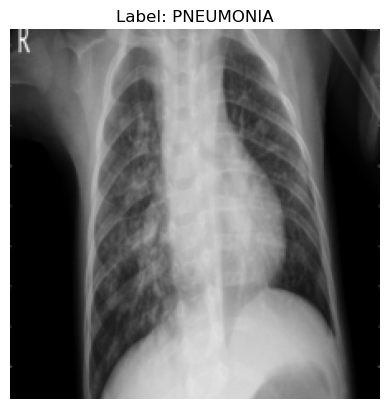

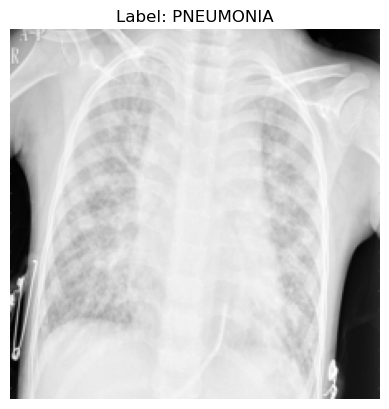

In [19]:
import matplotlib.pyplot as plt
import numpy as np

#image batch
dataiter = iter(train_loader)
images, labels = next(dataiter) #image, label pair


img_ten = images[0] #getting the 0th image/label pair
label = labels[0]

#tensor to NumPy (tensors no work for plotting :P)
img_np = img_ten.numpy()
img_np = np.transpose(img_np, (1, 2, 0))  #NOTE that the height/width need to be reordered when converting

#Image plot with the label on the top (thanks Chodrow!!!)
plt.imshow(img_np, cmap='gray')
plt.title(f"Label: {train_dataset.classes[label]}")
plt.axis("off")
plt.show()

i=10
pnu_img_ten = images[i]

pnu_label = labels[i]

pnu_img_np = pnu_img_ten.numpy()
pnu_img_np = np.transpose(pnu_img_np, (1, 2, 0))

plt.imshow(pnu_img_np, cmap='gray')
plt.title(f"Label: {train_dataset.classes[pnu_label]}")
plt.axis('off')
plt.show()


In [20]:
#Image Dimension (for later)
pnu_img_ten.size()

torch.Size([1, 224, 224])

## Pneumonia Autoencoder

In [21]:
import torch.nn as nn
import torch
import torch.optim as optim
from PneumoniaAutoencoder import PneumoniaAutoencoder

# Instantiate model, loss, optimizer
device = torch.device("cuda" if torch.cuda.is_available() else "cpu") #easy to switch between cpu and gpu
model = PneumoniaAutoencoder().to(device)

### Autoencoder training

In [22]:
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=1e-3)

from tqdm import tqdm

num_epochs = 1

for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0

    # progress bar (really nice)
    pbar = tqdm(train_loader, desc=f"Epoch [{epoch+1}/{num_epochs}]")

    for images, _ in pbar:
        images = images.to(device)

        outputs = model(images)
        loss = criterion(outputs, images)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

        # Update bar
        pbar.set_postfix({'loss': loss.item()})

    avg_loss = running_loss / len(train_loader)
    print(f"Epoch [{epoch+1}/{num_epochs}], Avg Loss: {avg_loss:.4f}")

Epoch [1/1]: 100%|██████████| 163/163 [01:39<00:00,  1.64it/s, loss=0.00166]

Epoch [1/1], Avg Loss: 0.0151


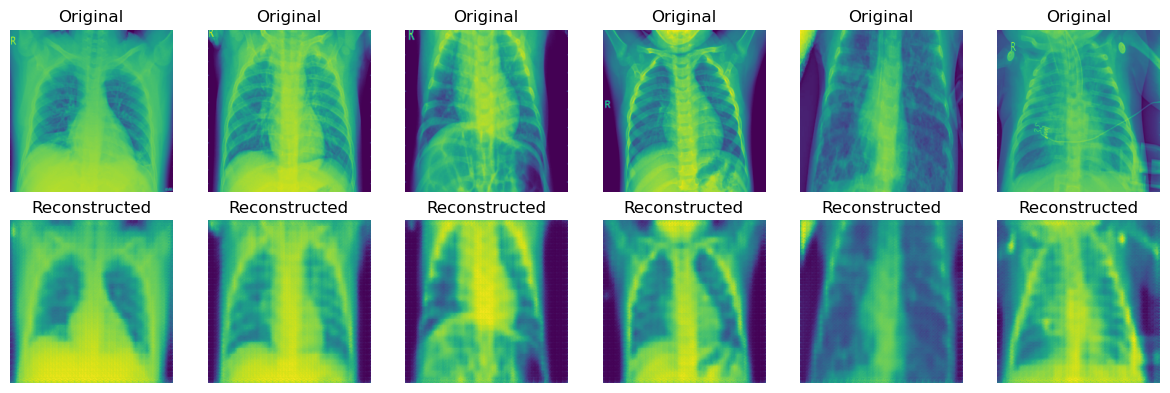

In [23]:
## reconstructed images

import matplotlib.pyplot as plt
import numpy as np

# eval
model.eval()

# batch
dataiter = iter(train_loader)
images, _ = next(dataiter)
images = images.to(device)

# Reconstruct images
with torch.no_grad():
    reconstructions = model(images)

# Move tensors to CPU for plotting (np can't use gpu)
images = images.cpu()
reconstructions = reconstructions.cpu()

#transpose for tensor --> numpy
def tensor_to_img(t):
    t = t.numpy()
    t = np.transpose(t, (1, 2, 0))
    return t

# Plot original and reconstructed
n = 6 #num images
plt.figure(figsize=(12, 4))
for i in range(n):
    # Original
    ax = plt.subplot(2, n, i + 1)
    plt.imshow(tensor_to_img(images[i]))
    ax.set_title("Original")
    plt.axis("off")

    # Reconstruction
    ax = plt.subplot(2, n, i + 1 + n)
    plt.imshow(tensor_to_img(reconstructions[i]))
    ax.set_title("Reconstructed")
    plt.axis("off")

plt.tight_layout()
plt.show()


### Autoencoder PCA plot 
This to check if differences encoded are meaningful.

In [24]:
model.eval()
latent_vectors = []
labels_list = []

with torch.no_grad():
    for images, labels in train_loader:  # labels: 0=norm, 1=pneu
        images = images.to(device)
        encoded = model.encoder(images)
        # Flatten
        encoded = encoded.view(encoded.size(0), -1).cpu().numpy()
        latent_vectors.append(encoded)
        labels_list.append(labels.cpu().numpy())

# Stack into arrays
import numpy as np
X = np.vstack(latent_vectors)
y = np.hstack(labels_list)

from sklearn.decomposition import PCA

pca = PCA(n_components=2) #2 Principal components
X_pca = pca.fit_transform(X)

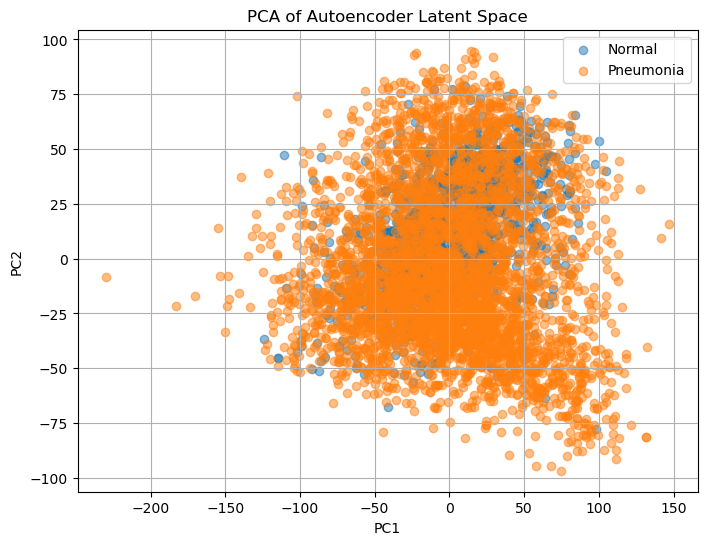

In [25]:
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 6))
plt.scatter(X_pca[y==0, 0], X_pca[y==0, 1], label="Normal", alpha=0.5)
plt.scatter(X_pca[y==1, 0], X_pca[y==1, 1], label="Pneumonia", alpha=0.5)
plt.title("PCA of Autoencoder Latent Space")
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.legend()
plt.grid(True)
plt.show()


## Variational AutoEncoder with Contrastive loss

In [26]:
# Contrastive loss function for VAE
def supervised_contrastive_loss(embeddings, labels: torch.Tensor, temperature=0.1):
    device = embeddings.device
    labels = labels.contiguous().view(-1, 1)
    mask = torch.eq(labels, labels.T).float().to(device)

    dot_product = (embeddings @ embeddings.T) / temperature
    logits_max, _ = torch.max(dot_product, dim=1, keepdim=True)
    logits = dot_product - logits_max.detach()

    exp_logits = torch.exp(logits) * (1 - torch.eye(len(labels), device=device))
    log_prob = logits - torch.log(exp_logits.sum(1, keepdim=True) + 1e-8)

    mean_log_prob_pos = (mask * log_prob).sum(1) / mask.sum(1)
    loss = -mean_log_prob_pos.mean()
    return loss

In [27]:
import numpy as np
from sklearn.decomposition import PCA
from ContrastiveVAE import ContrastiveVAE

def train_vae(model: ContrastiveVAE, dataloader, optimizer, device, epochs=10, beta=1.0, contrastive_weight=1.0):
    model.train()
    recon_loss_fn = nn.MSELoss(reduction='sum')

    for epoch in range(epochs):
        total_loss = 0
        for x, y in tqdm(dataloader, desc=f"Epoch {epoch+1}/{epochs}"):
            x, y = x.to(device), y.to(device)
            optimizer.zero_grad()

            x_recon, mu, logvar = model(x)
            recon_loss = recon_loss_fn(x_recon, x) / x.size(0)

            kl_loss = -0.5 * torch.mean(1 + logvar - mu.pow(2) - logvar.exp())

            contrastive = supervised_contrastive_loss(mu, y)

            loss = recon_loss + beta * kl_loss + contrastive_weight * contrastive
            loss.backward()
            optimizer.step()

            total_loss += loss.item()

        print(f"Epoch {epoch+1} - Loss: {total_loss / len(dataloader):.4f}")


### Training ConstrastiveVAE

In [28]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = ContrastiveVAE(latent_dim=64).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

train_vae(
    model,
    train_loader,
    optimizer,
    device,
    epochs=3,
    beta=1.0,
    contrastive_weight=5 # 5 ~208, 10 ~ 229
)


Epoch 1/3: 100%|██████████| 163/163 [03:42<00:00,  1.36s/it]


Epoch 1 - Loss: 1637.1428


Epoch 2/3: 100%|██████████| 163/163 [03:37<00:00,  1.33s/it]


Epoch 2 - Loss: 491.2045


Epoch 3/3: 100%|██████████| 163/163 [03:56<00:00,  1.45s/it]

Epoch 3 - Loss: 341.2160


In [29]:
import plotly.express as px

def plot_latent_space_3d(model, dataloader, device):
    model.eval()
    mus = []
    labels = []

    with torch.no_grad():
        for x, y in dataloader:
            x = x.to(device)
            x_recon, mu, logvar = model(x)
            mus.append(mu.cpu().numpy())
            labels.append(y.numpy())

    mus = np.concatenate(mus, axis=0)
    labels = np.concatenate(labels, axis=0)

    # PCA
    pca = PCA(n_components=3)
    reduced = pca.fit_transform(mus)

    # pd.data.frame for plotly!
    import pandas as pd
    df = pd.DataFrame({
        'PC1': reduced[:, 0],
        'PC2': reduced[:, 1],
        'PC3': reduced[:, 2],
        'Label': labels
    })

    fig = px.scatter_3d(df, x='PC1', y='PC2', z='PC3',
                        color=df['Label'].astype(str),
                        title='3D PCA of Latent Space',
                        labels={'color': 'Class'},
                        opacity=0.7)
    fig.update_traces(marker=dict(size=4))
    fig.show()


In [30]:
plot_latent_space_3d(model, train_loader, device)

## Training and Classification with Muliple Modeles

### Train, Test Split

In [31]:
def extract_latent_vectors(model, dataloader, device):
    model.eval()
    all_mu = []
    all_labels = []

    with torch.no_grad():
        for x, y in dataloader:
            x = x.to(device)
            mu, _ = model.encode(x)
            all_mu.append(mu.cpu().numpy()) #add all into np array
            all_labels.append(y.numpy())

    X = np.concatenate(all_mu, axis=0)
    y = np.concatenate(all_labels, axis=0)
    return X, y


In [32]:

X_train, y_train = extract_latent_vectors(model, train_loader, device)
X_test, y_test = extract_latent_vectors(model, test_loader, device)
# X_train.shape is (5216, 64)

### Logistic Regression

In [33]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix

model_test = LogisticRegression(max_iter=100, verbose = 1)
model_test.fit(X_train, y_train)

y_pred = model_test.predict(X_test)
print("Accuracy:", accuracy_score(y_test, y_pred))
print(classification_report(y_test, y_pred, digits=4))


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           65     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  6.93147D-01    |proj g|=  2.42906D-01

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
   65     19     22      1     0     0   3.585D-05   1.468D-01
  F =  0.14681073272165202     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
Accuracy: 0.7435897435897436
              precision    recall  f1-score   support

           0     0.9405    0.3376    0.4969       234
           1     0.7130    0.9872    0.8280       390

 

 This problem is unconstrained.


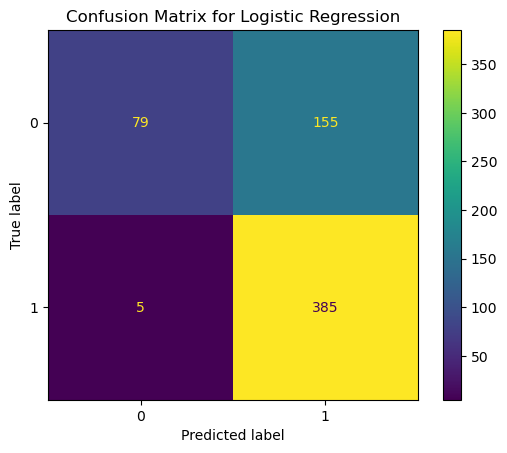

In [34]:
from sklearn.metrics import ConfusionMatrixDisplay

ConfusionMatrixDisplay.from_estimator(model_test, X_test, y_test)
plt.title("Confusion Matrix for Logistic Regression")
plt.show()


### Transformer

In [35]:
from Transformer import Transformer

# latent_vectors = X_train.shape[0] # 5216 latent vectors
latent_dim = X_train.shape[1] # 64 dimensions of latent space
output_dim = 2

# Initialize the Transformer model
T = Transformer(input_dim = latent_dim, num_patches = 1, output_dim=output_dim, hidden_dim=latent_dim).to(device)

# Train the Transformer model
def train_transformer(model: Transformer, X_train, y_train, device, epochs=3, batch_size=32):
    X = torch.tensor(X_train, dtype=torch.float32).to(device)  # [vectors, dim]
    y = torch.tensor(y_train, dtype=torch.long).to(device)  # [labels]
    
    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
    
    model.train()
    for epoch in range(epochs):
        total_loss = 0
        i = 0
        # Simulates batch loading method without dataloader
        while i < X.shape[0]: # Simulates batch loading method without dataloader
            # Create batches
            x_batch = X[i:i + batch_size]
            y_batch = y[i:i + batch_size]

            optimizer.zero_grad()
            outputs = model(x_batch)  
            loss = criterion(outputs, y_batch)  
            loss.backward()  
            optimizer.step()  

            total_loss += loss.item()
            i += batch_size  

        print(f"Epoch {epoch + 1} - Loss: {total_loss / (X.shape[0] // batch_size):.4f}")



In [36]:
train_transformer(T, X_train, y_train, device, epochs=10)

Epoch 1 - Loss: 0.3124
Epoch 2 - Loss: 0.1490
Epoch 3 - Loss: 0.1443
Epoch 4 - Loss: 0.1388
Epoch 5 - Loss: 0.1356
Epoch 6 - Loss: 0.1356
Epoch 7 - Loss: 0.1317
Epoch 8 - Loss: 0.1343
Epoch 9 - Loss: 0.1301
Epoch 10 - Loss: 0.1290


In [43]:
# Test loop
def test_transformer(model: Transformer, X_test, y_test, device, batch_size=32):
    X = torch.tensor(X_test, dtype=torch.float32).to(device)  # [vectors, dim]
    y = torch.tensor(y_test, dtype=torch.long).to(device)  # [labels]
    X, y = X.to(device), y.to(device)
    
    y_preds = []
    y_trues = []
    
    model.eval()
    with torch.no_grad():
        i = 0
        while i < X.shape[0]: 
            # Create batches
            x_batch = X[i:i + batch_size]
            y_batch = y[i:i + batch_size]

            outputs = model(x_batch)  # (batch_size, num_classes)
            preds = outputs.argmax(dim=1)  # Predicted labels

            y_preds.append(preds)
            y_trues.append(y_batch)

            i += batch_size
            
    # 2. Concatenate all batches
    y_preds = torch.cat(y_preds).cpu().numpy()
    y_trues = torch.cat(y_trues).cpu().numpy()

    # 3. Calculate accuracy and classification report
    acc = accuracy_score(y_trues, y_preds)
    print(confusion_matrix(y_trues, y_preds))
    print(classification_report(y_trues, y_preds))
    
    return acc

In [44]:
test_transformer(T, X_test, y_test, device)

[[ 95 139]
 [  7 383]]
              precision    recall  f1-score   support

           0       0.93      0.41      0.57       234
           1       0.73      0.98      0.84       390

    accuracy                           0.77       624
   macro avg       0.83      0.69      0.70       624
weighted avg       0.81      0.77      0.74       624



0.7660256410256411

TypeError: from_predictions() takes 3 positional arguments but 4 were given